In [1]:
! pip install pykalman

## Example

In [2]:
from pykalman import KalmanFilter
import numpy as np
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
# (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
# (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
kf.__dict__

{'transition_matrices': array([[1, 1],
        [0, 1]]),
 'observation_matrices': array([[ 0.1,  0.5],
        [-0.3,  0. ]]),
 'transition_covariance': array([[1.3939454 , 0.00828761],
        [0.00828761, 0.3269986 ]]),
 'observation_covariance': array([[ 0.34180639, -0.07294099],
        [-0.07294099,  0.18519393]]),
 'transition_offsets': array([0., 0.]),
 'observation_offsets': array([0., 0.]),
 'initial_state_mean': array([-0.62893648,  0.36286253]),
 'initial_state_covariance': array([[ 0.28058382, -0.06524256],
        [-0.06524256,  0.11905581]]),
 'random_state': None,
 'em_vars': ['transition_covariance',
  'observation_covariance',
  'initial_state_mean',
  'initial_state_covariance'],
 'n_dim_state': 2,
 'n_dim_obs': 2}

## Comparison

In [3]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [4]:
IBMQ.load_account()

<ipython-input-4-beb09c0bf764>:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = IBMQ.get_provider(hub="ibm-q-ncsu", group="lehigh-universit", project="qc-error-model") # ibm-q-ncsu/lehigh-universit/qc-error-model
name = "ibm_nairobi"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

In [6]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.ccx(0,1,2)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

In [7]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)
    
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()

total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))

In [8]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [9]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [11]:
# Use existing code to construct arguemented system
observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [12]:
kfobj_for_em = KalmanFilter(transition_matrices = learn_obj.Fa.todense().real, observation_matrices = learn_obj.Ha.todense().real)
measurements = np.asarray(learn_obj.ys)
kfobj_for_em = kfobj_for_em.em(measurements, n_iter=8)
kfobj_for_em.__dict__

{'transition_matrices': array([[ 5.0000000e-01,  5.0000000e-01,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  5.0000000e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00, -1.7431528e-32, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]),
 'observation_matrices': array([[0.5, 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , .

In [13]:
(smoothed_state_means, smoothed_state_covariances) = kfobj_for_em.smooth(measurements)

In [14]:
smoothed_state_means.shape

(10, 128)

In [15]:
smoothed_state_covariances.shape

(10, 128, 128)

In [16]:
norm_diffs = []

for i in range(len(total_simu_dens)):
    kf_state = smoothed_state_means[i][:num_dim_state].flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
    norm_diff = np.linalg.norm(kf_state - total_simu_dens[i].data)
    norm_diffs.append(norm_diff)
    print(norm_diff)

0.3670252632235794
0.3067499988647804
0.25484744930150505
0.22076117659524302
0.18960887888152334
0.171708332447256
0.16417027858569877
0.16122064522092597
0.16134245798118402
0.16222781222300686


In [17]:
kf_state

array([[ 0.20209839,  0.0085687 ,  0.16400747,  0.00639947,  0.00526678,
        -0.17129588,  0.02061783,  0.18391882],
       [ 0.0085687 ,  0.08095273, -0.034164  , -0.02470647,  0.00848402,
        -0.00671804, -0.02277572,  0.04490952],
       [ 0.16400747, -0.034164  ,  0.18861147,  0.00802677, -0.01910398,
        -0.12513541,  0.00728193,  0.13938817],
       [ 0.00639947, -0.02470647,  0.00802677,  0.0741618 ,  0.0109782 ,
        -0.02334774,  0.03040325, -0.00583067],
       [ 0.00526678,  0.00848402, -0.01910398,  0.0109782 ,  0.07398354,
         0.01105923,  0.01074016,  0.00384237],
       [-0.17129588, -0.00671804, -0.12513541, -0.02334774,  0.01105923,
         0.16261775,  0.03364632, -0.1731168 ],
       [ 0.02061783, -0.02277572,  0.00728193,  0.03040325,  0.01074016,
         0.03364632,  0.06034579, -0.02341363],
       [ 0.18391882,  0.04490952,  0.13938817, -0.00583067,  0.00384237,
        -0.1731168 , -0.02341363,  0.15722614]])

In [18]:
# Use own codes
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
# realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
# realX0 = KSEM.closed_den_mat(realX0) # find closest valid density matrix
# realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll -6810.53, Last ll -6820.53
Iteration     1, New log-likelihood -6.68095e+03, Last log-likelihood -6.81053e+03, Change 1.29577e+02
Iteration     2, New log-likelihood 6.75159e+07, Last log-likelihood -6.68095e+03, Change 6.75226e+07


In [19]:
smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 

In [20]:
norm_diffs2 = []
for i in range(len(total_simu_dens)):
    kf_state2 = x_seq[i].todense()[:num_dim_state].flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
    norm_diff = np.linalg.norm(kf_state2 - total_simu_dens[i].data)
    norm_diffs2.append(norm_diff)
    print(norm_diff)

0.9553198724879353
43.38215113965615
183.21634522000457
123.62400442921118
141.05357759408253
127.69333762512028
145.11432680101268
288.9058868552316
242.71696735895182
145.73901586859083


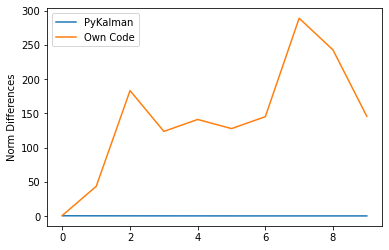

In [21]:
plt.plot(list(range(10)), norm_diffs, label='PyKalman')
plt.plot(list(range(10)), norm_diffs2, label='Own Code')
plt.ylabel('Norm Differences')
plt.legend()
plt.show()

In [22]:
# State tomogtaphy

backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)


tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))

In [23]:
norm_diffs3 = []
for i in range(len(total_simu_dens)):
    norm_diff = np.linalg.norm(tomo_dens[i] - total_simu_dens[i].data)
    norm_diffs3.append(norm_diff)
    print(norm_diff)

0.6802311175834849
0.8035967286810904
0.697028523155237
0.6464038970007006
0.6359881309793738
0.5768496449720498
0.5576417312684137
0.5320558048923371
0.5271771836005364
0.5316026592921906


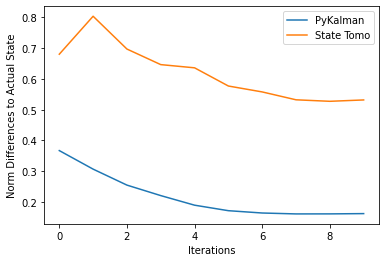

In [24]:
plt.plot(list(range(10)), norm_diffs, label='PyKalman')
# plt.plot(list(range(10)), norm_diffs2, label='Own Code')
plt.plot(list(range(10)), norm_diffs3, label='State Tomo')
plt.xlabel('Iterations')
plt.ylabel('Norm Differences to Actual State')
plt.legend()
plt.show()

In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
norm_diffs = np.array(
[0.3670252632235794,
0.3067499988647804,
0.25484744930150505,
0.22076117659524302,
0.18960887888152334,
0.171708332447256,
0.16417027858569877,
0.16122064522092597,
0.16134245798118402,
0.16222781222300686])

In [4]:
norm_diffs3 = np.array(
[0.6802311175834849,
0.8035967286810904,
0.697028523155237,
0.6464038970007006,
0.6359881309793738,
0.5768496449720498,
0.5576417312684137,
0.5320558048923371,
0.5271771836005364,
0.5316026592921906])

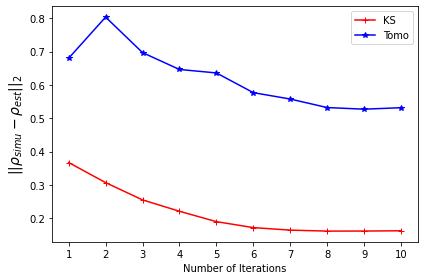

In [8]:

    
iter_range = range(10)
plt.plot(np.array(iter_range)+1, np.array(norm_diffs)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(norm_diffs3)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("pkalman_ibm_nairobi_Harder_Case_diff_norm.svg")
plt.show()

In [12]:
KS_norm = np.array([0.06571062963610429,
                   0.06952401593303774,
                    0.07097250534726701,
                   0.06845746512488939,
                   0.0650887989394933,
                   0.06687733815172905,
                   0.0673818001551706,
                    0.0650750865056518,
                   0.06844639778354121,
                    0.06625505479546008])
Tomo_norm =  np.array([0.09185528841730818,
0.10165721020106024,
0.09674697983805347,
0.09260881904639025,
0.09068417005443226,
0.09461849133176234,
0.08885919583245001,
0.09740241728032667,
0.09447299339090132,
0.09852003622325411])

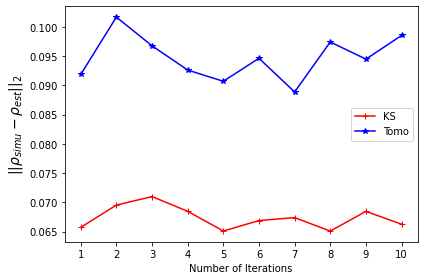

In [13]:
iter_range = range(10)
plt.plot(np.array(iter_range)+1, np.array(KS_norm)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(Tomo_norm)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
plt.savefig("ibm_perth_4q_iden_diff_norm.svg")
plt.show()